In [1]:
#including libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import os


Using TensorFlow backend.


In [2]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#extracting dataset
!tar -xzf ./drive/My\ Drive/flower_photos.tgz -C ./drive/My\ Drive/

In [4]:
import errno
import os,shutil

dataset_dir= './drive/My Drive/flower_photos'
print(os.listdir(dataset_dir))

['roses', 'sunflowers', 'tulips', 'daisy', 'dandelion', '.ipynb_checkpoints']


In [0]:
#reading images

#REFERENCE: https://www.kaggle.com/albertovilla/applying-restnet50-to-flower-classification

def reading_images(direc):
  classes=[]
  img=[]
  classes_f = os.listdir(dataset_dir)
  for fc in classes_f:
    cl_folder, img_folder = img_from_data_dir(direc,fc)
    classes.extend(cl_folder)
    img.extend(img_folder)
  return classes,img

def img_from_data_dir(direc,fc):
  folder_path= os.path.join(dataset_dir,fc)
  files_dir = os.listdir(folder_path)
  classes=[]
  img=[]
  for f in files_dir:
    if f.endswith('.jpg'):
      classes.append(fc)
      img.append(os.path.join(folder_path,f))
  return classes,img
classes,img = reading_images(dataset_dir)  

In [0]:
#splitting dataset

from sklearn.model_selection import train_test_split
train_img, test_img, train_class, test_class = train_test_split(img,classes, test_size=0.2, random_state = 8, stratify = classes)

In [0]:
#creating directory for training and testing datasets and copying images

#REFERENCE: https://www.kaggle.com/albertovilla/applying-restnet50-to-flower-classification

split_folder='./drive/My Drive/flower_photos/split/'
train_folder='./drive/My Drive/flower_photos/split/train'
test_folder='./drive/My Drive/flower_photos/split/test'

def split_folders():
  if not os.path.exists(split_folder):
    os.mkdir(split_folder)
    if not os.path.exists(train_folder):
      os.mkdir(train_folder)
      for clas in set(classes):
        os.mkdir(train_folder + '/' + clas)
    if not os.path.exists(test_folder):
      os.mkdir(test_folder)
      for clas in set(classes):
        os.mkdir(test_folder + '/' + clas)
        
def copy_img():
  for i,n in enumerate(train_img):
    m= os.path.join(train_folder,train_class[i])
    shutil.copy(n,m)
  for i,n in enumerate(test_img):
    m= os.path.join(test_folder,test_class[i])
    shutil.copy(n,m)
    
split_folders()
copy_img()

In [8]:
#using ImageDataGenerator and flow_from_directory for data pre-processing

training_datagenerator = ImageDataGenerator(rescale=1./255, validation_split=0.1)

testing_datagenerator = ImageDataGenerator(rescale=1./255)

train_generator= training_datagenerator.flow_from_directory(
  train_folder, target_size=(224,224),batch_size=100,subset="training")

val_generator= training_datagenerator.flow_from_directory(
  train_folder, target_size=(224,224),batch_size=100,subset="validation")

test_generator = testing_datagenerator.flow_from_directory(test_folder,target_size=(224,224),batch_size=100)


Found 2646 images belonging to 5 classes.
Found 290 images belonging to 5 classes.
Found 734 images belonging to 5 classes.


In [9]:
labels= train_generator.class_indices.keys()
print(labels)

dict_keys(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])


In [10]:
#create Convolutional neural network

cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)))
cnn_model.add(layers.MaxPooling2D((2,2)))

cnn_model.add(layers.Conv2D(64,(3,3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2,2)))

cnn_model.add(layers.Conv2D(64,(3,3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2,2)))

cnn_model.add(layers.Conv2D(128,(3,3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2,2)))

cnn_model.add(layers.Conv2D(128,(3,3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2,2)))
              
cnn_model.add(layers.Conv2D(32,(3,3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2,2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(256,activation='relu'))
cnn_model.add(layers.Dropout(0.5))                      #to reduce overfitting
cnn_model.add(layers.Dense(5,activation='softmax'))

cnn_model.summary()

#compiling model by providing loss function,optimizer and metrics

cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizers.Adam(),
                 metrics=['accuracy'])

#training model

cnn_model_history= cnn_model.fit_generator(train_generator,steps_per_epoch=100,epochs=30,validation_data=val_generator,validation_steps=50, verbose=2 )




W0628 03:17:53.558228 140164481435520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

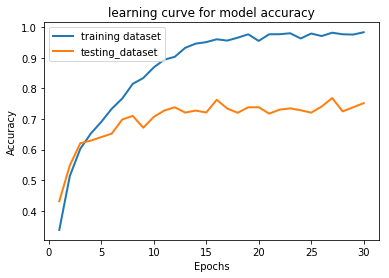

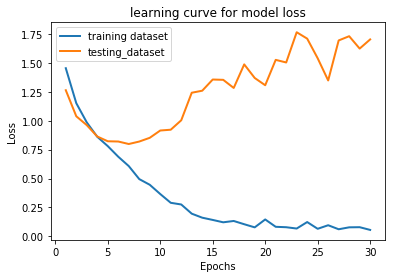

test acc: 0.75390965


In [11]:
#learning curve

acc = cnn_model_history.history['acc']
val_acc = cnn_model_history.history['val_acc']
loss = cnn_model_history.history['loss']
val_loss = cnn_model_history.history['val_loss']

epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,linewidth=2)
plt.plot(epochs,val_acc,linewidth=2)
plt.title('learning curve for model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training dataset','testing_dataset'],loc='upper left')
plt.show()

epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,linewidth=2)
plt.plot(epochs,val_loss,linewidth=2)
plt.title('learning curve for model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training dataset','testing_dataset'],loc='upper left')
plt.show()


test_loss, test_acc = cnn_model.evaluate_generator(test_generator,steps=50)
print('test acc:',test_acc)

In [12]:
# transfer learning using feature extraction

from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(224,224,3))

#vgg_base.summary()

#creating top layers

vgg_model= models.Sequential()
vgg_model.add(vgg_base)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(256,activation='relu'))
#vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.Dense(5,activation='softmax'))

vgg_model.summary()

print(len(vgg_model.trainable_weights))



58892288/58889256 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 21,138,757
Trainable params: 21,138,757
Non-trainable params: 0
_________________________________________________________________
30


In [13]:
vgg_base.trainable = False
print(len(vgg_model.trainable_weights))

4


In [14]:
#using ImageDataGenerator and flow_from_directory for data pre-processing and data augmentation

training_datagenerator = ImageDataGenerator(rescale=1./255, 
                                            validation_split=0.1, 
                                            rotation_range=30,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            shear_range=0.1,
                                            zoom_range=0.1,
                                            horizontal_flip=True,
                                            fill_mode='nearest')

testing_datagenerator = ImageDataGenerator(rescale=1./255)

train_generator= training_datagenerator.flow_from_directory(
  train_folder, target_size=(224,224),batch_size=100,subset="training")

val_generator= training_datagenerator.flow_from_directory(
  train_folder, target_size=(224,224),batch_size=100,subset="validation")

test_generator = testing_datagenerator.flow_from_directory(test_folder,target_size=(224,224),batch_size=100)


Found 2646 images belonging to 5 classes.
Found 290 images belonging to 5 classes.
Found 734 images belonging to 5 classes.


In [15]:
#compiling model by providing loss function,optimizer and metrics
vgg_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizers.Adam(),
                 metrics=['accuracy'])

#training model

vgg_model_history= vgg_model.fit_generator(train_generator,steps_per_epoch=100,epochs=30,validation_data=val_generator,validation_steps=50, verbose=2)


Epoch 1/30
100/100 - 269s - loss: 1.1075 - acc: 0.7145 - val_loss: 0.7269 - val_acc: 0.7690
Epoch 2/30
100/100 - 257s - loss: 0.3972 - acc: 0.8576 - val_loss: 0.5849 - val_acc: 0.8056
Epoch 3/30
100/100 - 251s - loss: 0.2822 - acc: 0.9009 - val_loss: 0.5854 - val_acc: 0.8112
Epoch 4/30
100/100 - 244s - loss: 0.2295 - acc: 0.9200 - val_loss: 0.7420 - val_acc: 0.7711
Epoch 5/30
100/100 - 258s - loss: 0.2044 - acc: 0.9268 - val_loss: 0.6315 - val_acc: 0.8097
Epoch 6/30
100/100 - 253s - loss: 0.1515 - acc: 0.9500 - val_loss: 0.6539 - val_acc: 0.8128
Epoch 7/30
100/100 - 242s - loss: 0.1464 - acc: 0.9491 - val_loss: 0.6866 - val_acc: 0.8159
Epoch 8/30
100/100 - 259s - loss: 0.1060 - acc: 0.9649 - val_loss: 0.7165 - val_acc: 0.8093
Epoch 9/30
100/100 - 254s - loss: 0.1032 - acc: 0.9652 - val_loss: 0.8058 - val_acc: 0.7911
Epoch 10/30
100/100 - 245s - loss: 0.0873 - acc: 0.9708 - val_loss: 0.7342 - val_acc: 0.8147
Epoch 11/30
100/100 - 243s - loss: 0.0783 - acc: 0.9742 - val_loss: 0.8423 - va

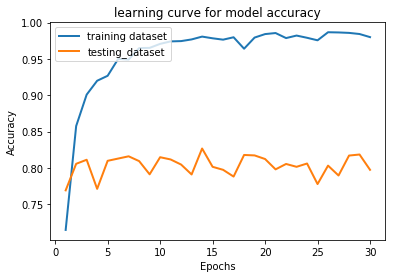

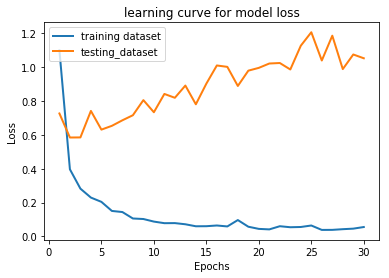

test acc: 0.8414422


In [16]:
acc = vgg_model_history.history['acc']
val_acc = vgg_model_history.history['val_acc']
loss = vgg_model_history.history['loss']
val_loss = vgg_model_history.history['val_loss']

epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,linewidth=2)
plt.plot(epochs,val_acc,linewidth=2)
plt.title('learning curve for model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training dataset','testing_dataset'],loc='upper left')
plt.show()

epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,linewidth=2)
plt.plot(epochs,val_loss,linewidth=2)
plt.title('learning curve for model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training dataset','testing_dataset'],loc='upper left')
plt.show()


test_loss, test_acc = vgg_model.evaluate_generator(test_generator,steps=50)
print('test acc:',test_acc)

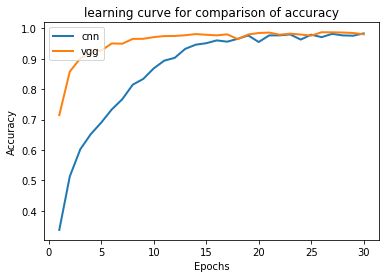

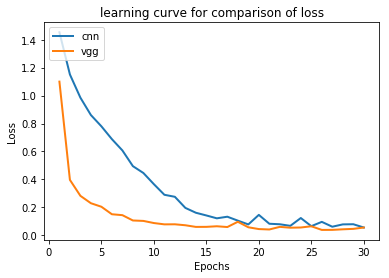

In [17]:
cnn_acc = cnn_model_history.history['acc']
vgg_acc = vgg_model_history.history['acc']
cnn_loss = cnn_model_history.history['loss']
vgg_loss = vgg_model_history.history['loss']

epochs=range(1,len(acc)+1)
plt.plot(epochs,cnn_acc,linewidth=2)
plt.plot(epochs,vgg_acc,linewidth=2)
plt.title('learning curve for comparison of accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['cnn','vgg'],loc='upper left')
plt.show()

epochs=range(1,len(loss)+1)
plt.plot(epochs,cnn_loss,linewidth=2)
plt.plot(epochs,vgg_loss,linewidth=2)
plt.title('learning curve for comparison of loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['cnn','vgg'],loc='upper left')
plt.show()

